In [1]:
from IPython.display import display, Math, Latex

import pandas as pd
import numpy as np
import numpy_financial as npf
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime, date

import random

## CFM 101: Group Assignment - Python Roboadvisor
### Team Number: 15
### Team Member Names: Landon Trinh, Ethan Zemelman, Jessie Deng
### Team Strategy Chosen: SAFE

## Goal
- The focus of this project is to dynamically generate the safest possible portfolio given a file of unknown stock tickers.
- Our roboadvisor will run from November 25, 2023 to December 4, 2023
- At the end of the real-time simulation, the deviation will be calculated by taking calculating the difference between the final value of the portfolio and the initial portfolio value ($750,000)
- Ultimately, our aim is to have our portfolio deviate in nominal value. In other words, in the end, we want our portfolio value to have changed as little as possible

## Process
1. Filter Stock Data
2. Select Candidates of Stocks
3. Select Optimal Weightings


## Introduction
> "Theory will only take you so far." - J. Robert Oppenheimer

To build a safe portfolio, we will heavily focus on diversification. Diversification is a risk management strategy that focuses on mixing a wide variety of investments within a portfolio in attempt to reduce portfolio risk. Hence, we plan to create 3 sets of 25 stocks in order to maximize diversification and reduce portfolio risk.

Our process has been split into two main components:
1. Stock Selection
- Lowest standard deviations
- Zero-beta portfolio
- Oppositely correlated stocks


2. Portfolio Weightings
- Select random weights for stocks
- Run N simulations
- Optimize for LOWEST expected returns

Our goal will be to tell a convincing story to WHY we are picking our stocks. We will calculate and discuss statistics, display and intepret graphs, and explain our thought process

## 1. Setup
Before implementing our trading strategy, we will initialize required and useful constants as part of the rules:
- Currency of valid stocks (USD or CAD)
- Required average monthly volume (150,000 shares)
- The number of stocks we wish to purchase on the start date (10-22 stocks)
- Time interval (Janurary 1, 2023 - October 31, 2023)
- Minimum number of trading days for month (18 days)
- Minimum stock weighting: $\frac{100}{2n}$%, $n$ = number of stocks in portfolio
- Maximum stock weighting: 20%
- Initial investment amount: $750,000 CAD
- Buying date of roboadvisor: November 25, 2023 - December 4, 2023
- Trading fee for each stock trade: $4.95 CAD

In the end, our roboadvisor should create two DataFrames:

1. $\verb|Portfolio_Final|\\$
- Index: Starts at 1 and ends at number of stocks in portfolio
- Headings: Ticker, Price (price of stock on Nov 25), Currency (CAD or USD), Shares, Value, Weight (adds to 100%)

2. $\verb|Stocks_Final|\\$
We should output this DataFrame to a CSV file titled "Stocks_Group_15.csv"
- Index: Same as "Portfolio Final"
- Headings: Tickers and Shares from "Portfolio_Final"


In [2]:
# Investment amount (CAD)
capital = 750_000

# Number of stocks to buy for portfolio
num_stocks = 15

# Maximum and minimum weightings of each stock in portfolio
min_weight = 1 / (2 * num_stocks)
max_weight = 0.20

# Start and end date for roboadvisor
# start_date = "2023-11-25"
# end_date = "2023-12-04"

# Filtering requirements
min_trading_days = 18
min_avg_volume = 150000

## 2. Filtering
After reading in the CSV file containg stock tickers, we must filter the list of stocks to make sure they are valid stock tickers according to the following rules:
- Include stocks that have an average monthly volume of at leaest 150,000 shares based on Jan 1, 2023 - Oct 31, 2023 (drop any months that don't have at least 18 trading days)
- Stock denominated in USD or CAD

In [4]:
# Read in CSV ticker file
tickers = pd.read_csv("tickers_example.csv", header=None)
tickers = tickers.rename(columns={0: "ticker"})
tickers_lst = tickers["ticker"].tolist()
tickers.head(10)

,ticker
0,AAPL
1,ABBV
2,ABT
3,ACN
4,AGN
5,AIG
6,AMZN
7,AXP
8,BA
9,BAC


In [5]:
# Set parameters for filtering tickers
filter_start_date = "2023-01-01"
filter_end_date = "2023-10-31"
filter_interval = "1mo"

In [6]:
# Determines months with less than 18 trading days
def get_short_months(market_index):
    short_months = []
    for month in range(1, 11):
        trading_days = len(market_index.history(start=str(date(2023, month, 1)), end=str(date(2023, month+1, 1))))
        if trading_days < min_trading_days:
            short_months.append(month)
    return short_months

# Keeps stocks with valid average monthly volume
def filter_volume(tickers, short_months):

    # Retrieve monthly volume data for tickers
    volume_data = yf.download(tickers=tickers, interval="1mo", start=filter_start_date, end=filter_end_date).Volume

    # Drop short months from volume DataFrame
    for short_month in short_months:
        volume_data.drop(str(date(2023, short_month, 1)))

    # Determine whether stocks meets average monthly volume requirement
    for ticker in tickers:
        if (volume_data[ticker]).mean() < min_avg_volume:
            print(f"{ticker} does not meet the required minimum average monthly volume")
            tickers.remove(ticker)

    # Return finalized list of tickers
    return tickers


# Retrieve filtered tickers
def filter_tickers(tickers):
    
    # Initialize list to separately store CAD and USD tickers
    cad_tickers = []
    usd_tickers = []
    
    for ticker in tickers:
        try:
            stock_ticker = yf.Ticker(ticker)
            base_currency = stock_ticker.fast_info["currency"]
            
            # Store ticker in appropriate list
            if base_currency == "CAD":
                cad_tickers.append(ticker)
            
            elif base_currency == "USD":
                usd_tickers.append(ticker)
    
        except:
            print(f"{ticker} may be delisted")

    # Determine months that have less than 18 trading days for CAD and USD stocks
    cad_short_months = get_short_months(yf.Ticker("^GSPTSE"))
    usd_short_months = get_short_months(yf.Ticker("^GSPC"))

    # Filter months that have an average monty volume of less than 150k
    filtered_cad_tickers = filter_volume(cad_tickers, cad_short_months)
    filtered_usd_tickers = filter_volume(usd_tickers, usd_short_months)

    # Add to single list
    filtered_tickers = filtered_cad_tickers + filtered_usd_tickers
    return filtered_tickers
    
filtered_tickers = filter_tickers(tickers_lst)
print(filtered_tickers)

AGN may be delisted
CELG may be delisted
MON may be delisted
RTN may be delisted
[*********************100%%**********************]  4 of 4 completed
[*********************100%%**********************]  32 of 32 completed
['RY.TO', 'SHOP.TO', 'T.TO', 'TD.TO', 'AAPL', 'ABBV', 'ABT', 'ACN', 'AIG', 'AMZN', 'AXP', 'BA', 'BAC', 'BIIB', 'BK', 'BLK', 'BMY', 'C', 'CAT', 'CL', 'KO', 'LLY', 'LMT', 'MO', 'MRK', 'PEP', 'PFE', 'PG', 'PM', 'PYPL', 'QCOM', 'TXN', 'UNH', 'UNP', 'UPS', 'USB']


In [87]:
# Download stock data
stock_data = yf.download(tickers=filtered_tickers, interval="1d", start=filter_start_date, end=filter_end_date).Close.dropna()

# Get daily returns of stocks
daily_returns = stock_data.pct_change().dropna()
# daily_returns.index = daily_returns.index.tz_localize('UTC')
# daily_returns.index = daily_returns.index.tz_convert('UTC')
daily_returns.head()

[*********************100%%**********************]  36 of 36 completed


,AAPL,ABBV,ABT,ACN,AIG,AMZN,AXP,BA,BAC,BIIB,...,QCOM,RY.TO,SHOP.TO,T.TO,TD.TO,TXN,UNH,UNP,UPS,USB
Date,,,,,,,,,,,,,,,,,,,,,
2023-01-04 00:00:00+00:00,0.010314,0.008067,0.014875,-0.003404,0.014778,-0.007924,0.023246,0.042223,0.018800,-0.006676,...,0.040392,0.008904,0.037303,0.012158,0.013003,0.036517,-0.027264,0.007997,0.010440,0.031138
2023-01-05 00:00:00+00:00,-0.010605,-0.001222,-0.003687,-0.023613,-0.005481,-0.023726,-0.027302,0.006629,-0.002050,0.002880,...,-0.019098,-0.002942,-0.035171,-0.001126,-0.027024,-0.013241,-0.028821,-0.029440,-0.018463,-0.007821
2023-01-06 00:00:00+00:00,0.036794,0.018717,0.013809,0.023690,0.016375,0.035611,0.025541,0.039075,0.009979,0.028204,...,0.054296,0.012734,0.014950,0.015408,-0.000463,0.049302,0.000082,0.043973,0.029395,0.014014
2023-01-09 00:00:00+00:00,0.004089,-0.029361,-0.001602,0.016864,-0.010535,0.014870,0.001532,-0.020798,-0.015112,-0.016222,...,-0.006329,0.007437,0.005044,-0.002221,-0.003126,0.008678,0.000122,-0.002594,0.015312,0.006478
2023-01-10 00:00:00+00:00,0.004456,-0.012495,0.015158,0.004310,-0.006576,0.028732,0.010638,-0.009014,0.006787,0.024534,...,0.020068,0.011416,-0.016061,0.001113,-0.001161,0.009735,-0.008285,0.003878,-0.016071,0.001073


## 3. Stock Analysis

For this secetion, our aim is to generate 3 lists of 25 stocks that can be potential candidates for our final portfolio. 

Since we want to diversify our portfolio as much as possible to reduce overall risk, we will choose the maximum number of stocks allowed (25 stocks). We will also place a large focus on LOW-RISK assets to reduce volatility within our portfolio.

Based from our CFM 101 class, we will focus on the following main statistical analyses:

#### 3.1 - Standard Deviation
- Take 25 stocks with the LOWEST standard deviations

#### 3.2 - Beta
- Take 25 stocks with the LOWEST beta values (stock with beta less than 1 is considered less volatile)

#### 3.3 - Correlation
- Get pairs of stocks that have LOWEST correlation

## 3.1 - Standard Deviation

Standard deviation is a statistic that measures the dispersion of a dataset relative to its mean.

In finance, standard deviation is often used as a measure or a relative riskiness of an asset. For example, a volatile stock will have a high standard deviation while a stable blue-chip stock will have a lower standard deviation.

To create a safe portfolio, we want to select stocks that are less volatile. Hence, we will take a look at stocks that have the lowest standard deviations.

The function below simplies calculates the standard deviation of the daily historical returns of each stocks, and sorts it from lowest to highest.

$$\sigma_X=\sqrt{\frac{\sum(x_i-\overline{X})^2}{N}}
$$

In [66]:
# Get standard deviation of stocks
def get_stock_stds(filtered_tickers):

    # Store information
    stds = {}

    for stock in filtered_tickers:
        stock_std = daily_returns[stock].std()
        stds[stock] = stock_std

    # Sort from lowest to highest std
    return dict(sorted(stds.items(), key=lambda item: item[1]))

stds = get_stock_stds(filtered_tickers)
std_df = pd.DataFrame(stds.items(), columns=["ticker", "std"])
std_df

,ticker,std
0,KO,0.008796
1,RY.TO,0.009367
2,PG,0.009581
3,PEP,0.009822
4,CL,0.010570
5,T.TO,0.010654
6,TD.TO,0.010948
7,PM,0.011099
8,BMY,0.011738
9,MO,0.011773


In [76]:
def get_expected_returns(stock_lst):
    returns = []

    for stock in stock_lst:
        returns.append(daily_returns[stock].mean())
    
    exp_returns = sum(returns) / len(returns)
    return exp_returns



In [79]:
# Retrieve and graph expected returns of stocks with highest standard deviation
n_stocks = len(filtered_tickers)

# Get stocks with highest standard deviations
h_stock_std = std_df.nlargest(n_stocks // 2, columns="std")
h_stock_std_lst = h_stock_std["ticker"].tolist()
h_std_exp_ret = get_expected_returns(h_stock_std_lst)
print(f"Expected Return of High Std: {h_std_exp_ret}")

# Get stocks with lowest standard deviations
l_stock_std = std_df.nsmallest(n_stocks // 2, columns="std")
l_stock_std_lst = l_stock_std["ticker"].tolist()
l_std_exp_ret = get_expected_returns(l_stock_std_lst)
print(f"Expected Return of Low Std: {l_std_exp_ret}")

Expected Return of High Std: -9.093421851470439e-05
Expected Return of Low Std: -0.0004090682729620729


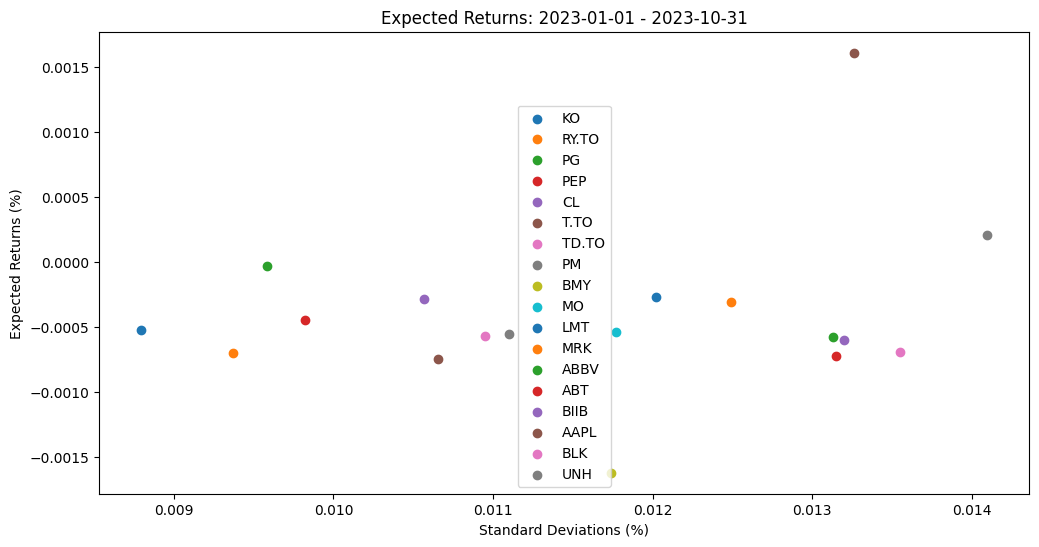

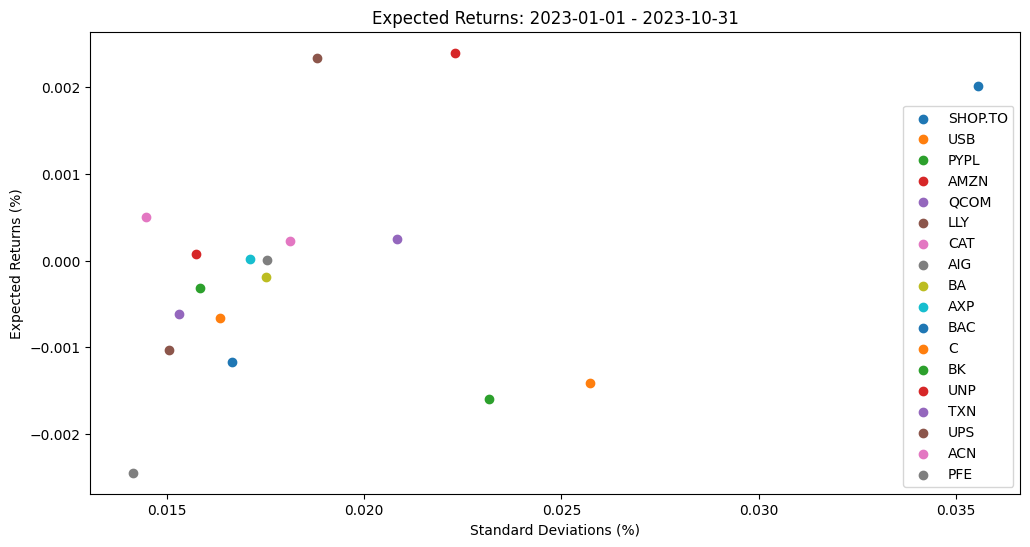

In [80]:
# Plot expected returns of highest standard deviations
def graph_expected_returns(stock_lst):
    plt.figure(figsize=(12,6))

    for stock in stock_lst:
        plt.scatter(stds[stock], daily_returns[stock].mean(), label=stock)
    plt.title(f"Expected Returns: {filter_start_date} - {filter_end_date}") 
    plt.xlabel("Standard Deviations (%)")
    plt.ylabel("Expected Returns (%)")
    plt.legend()
    plt.show()

graph_expected_returns(l_stock_std_lst)
graph_expected_returns(h_stock_std_lst)

As observed in the graphs above, stocks with a lower standard deviation tend to have lower expected returns on average. This is a good indication that the stocks with low standard deviations can be potential candidates

In [85]:
print(f"Stocks with Lowest Standard Deviations: {l_stock_std_lst}")

Stocks with Lowest Standard Deviations: ['KO', 'RY.TO', 'PG', 'PEP', 'CL', 'T.TO', 'TD.TO', 'PM', 'BMY', 'MO', 'LMT', 'MRK', 'ABBV', 'ABT', 'BIIB', 'AAPL', 'BLK', 'UNH']


## 3.2 Beta
The beta value of a stock measures its volatility relative to the broader market. A beta value greater than 1 indicates that the stock is more volatile than the market and a beta value less than 1 indicates a more stable stock. Since we are choosing to go safe with our portfolio, stocks need to be chosen so that the beta values are as low as possible.

We will be using the S&P 500 as out market index. Since a volatile stock may lead to capital gains/losses, we will seek the lowest magnitude beta values.

The aim will be to use Beta as a statistical measure to quantify our various portfolios which will allow us to choose the appropirate set of stocks.

A beta greater than 1.0 indicates that the stock is more voltatile than the broader market while a beta lass than 1.0 indicates a stock with lower volatility.
\begin{align*}
\beta=\frac{Cov(r_i,r_m)}{Var(r_m)}
\end{align*}

In [88]:
# Set S&P 500 as market index
market_index = yf.download(tickers="^GSPC", start=filter_start_date, end=filter_end_date)["Close"]
market_returns = market_index.pct_change().dropna()
market_returns.index = market_returns.index.tz_localize('UTC')
market_returns.index = market_returns.index.tz_convert('UTC')
market_variance = market_returns.var()

def get_stock_betas(stocks): 
        betas = {}
        for stock in stocks:
                stock_returns = daily_returns[stock]
                beta = stock_returns.cov(market_returns) / market_variance
                betas[stock] = beta
        
        # Return sorted betas in increasing order
        return dict(sorted(betas.items(), key=lambda item: item[1]))

betas = get_stock_betas(filtered_tickers).items()

betas_df = pd.DataFrame(betas, columns=["ticker", "beta"])
betas_df

[*********************100%%**********************]  1 of 1 completed


,ticker,beta
0,ABBV,0.159620
1,MRK,0.233888
2,UNH,0.282467
3,CL,0.295556
4,LMT,0.310787
5,PEP,0.354425
6,KO,0.360745
7,BMY,0.386441
8,T.TO,0.394628
9,PG,0.411532


## 3.3 - Correlation

In finance, correlation is a statistic that measures the dgree to which two securities move in relation to each other. Correlation is closely tied to diversification.
Correlations are computed as the correlation coefficent which has a value between -1 and 1. 

A positive correlation means when one security moves up or down, the other secuirty moves in the same direction. A negative correlation means that two assets move in opposite directions, while a zero correlation implies no linear relationship at all.

Hence, we hope to factor in negatively correlated stocks in our portfolio since their opposite movements in prices should theoreticlly offset each other to produce minimal volatility within the portfolio.

$$ COR(X,Y)=\frac{COV(X,Y)}{\sigma_X \times \sigma_Y} $$


$\sigma_X$ = deviation of the stock


$\sigma_Y$ = deviation of the market index

In [96]:
# Get market index data
market_index = "^GSPTSE"
market_return = pd.DataFrame(yf.download(tickers=market_index, interval="1d", start=filter_start_date, end=filter_end_date).Close.pct_change())
market_return = market_return.rename(columns={"Close": "S&P500"})

# Combine into single DataFrame
stock_market_data = pd.concat([stock_data, market_return], axis=1).dropna()
stock_market_returns = stock_market_data.pct_change()

# Get correlation of each stock with the S&P 500
correlation_index = pd.DataFrame(stock_market_returns.corr()["S&P500"])[:-1]
correlation_index = correlation_index.rename(columns={"S&P500": "corr"})
correlation_index

[*********************100%%**********************]  1 of 1 completed


,corr
AAPL,-0.095170
ABBV,-0.010146
ABT,-0.015275
ACN,-0.112333
AIG,-0.035829
AMZN,-0.154492
AXP,0.057096
BA,-0.059102
BAC,-0.001682
BIIB,0.001542


In [106]:
# Get stocks with highest correlation with S&P 500
lowest_correlations = correlation_index.nsmallest(n_stocks // 2, "corr")
lowest_correlations

# Get list
lowest_corr_lst = lowest_correlations.index.tolist()
lowest_corr_lst

# Get expected return if equally weighted
low_corr_returns = abs(get_expected_returns(lowest_corr_lst))
print(f"Expected Returns of low correlated stocks with Sp500 {low_corr_returns}")

Expected Returns of low correlated stocks with Sp500 0.0002445163226112


In [108]:
# Get stocks with lowest correlation with S&P 500
highest_correlations = correlation_index.nlargest(n_stocks // 2, "corr")
highest_correlations

highest_corr_lst = highest_correlations.index.tolist()
highest_corr_lst

high_corr_returns = abs(get_expected_returns(highest_corr_lst))
print(f"Expected Returns of highly correlated stocks with Sp500 {high_corr_returns}")

Expected Returns of highly correlated stocks with Sp500 0.0007445188140879774


As u can see, if equally weighted, the list of low correlated stocks produces a lower expected return.

### 3.3 - Correlation of Pairs of Stocks

Since we just finished looking at the correlation of each stock with the S&P 500, let's take a look at the correlation of the stocks with one another. 

Specifically, I want to create a correlation matrix and select the top 12 unique pairs of stocks that have the lowest correlations.


In [65]:
correlation_matrix = daily_returns.corr()
# print(correlation_matrix)

for stock in correlation_matrix.index:
    row = correlation_matrix.loc[stock]
    
    negative_correlations = [row[row < 0]]

    
    print(f"{stock}: {negative_correlations}")


AAPL: [ABBV   -0.032724
Name: AAPL, dtype: float64]
ABBV: [AAPL      -0.032724
AMZN      -0.161600
QCOM      -0.021110
SHOP.TO   -0.092689
Name: ABBV, dtype: float64]
ABT: [Series([], Name: ABT, dtype: float64)]
ACN: [MRK   -0.083084
Name: ACN, dtype: float64]
AIG: [Series([], Name: AIG, dtype: float64)]
AMZN: [ABBV   -0.161600
CL     -0.056695
MRK    -0.078095
UNH    -0.061156
Name: AMZN, dtype: float64]
AXP: [CL   -0.064712
Name: AXP, dtype: float64]
BA: [Series([], Name: BA, dtype: float64)]
BAC: [LLY   -0.017712
Name: BAC, dtype: float64]
BIIB: [Series([], Name: BIIB, dtype: float64)]
BK: [LLY   -0.017179
Name: BK, dtype: float64]
BLK: [LLY   -0.021031
Name: BLK, dtype: float64]
BMY: [QCOM   -0.020247
Name: BMY, dtype: float64]
C: [LLY   -0.091339
PEP   -0.010311
UNH   -0.001803
Name: C, dtype: float64]
CAT: [Series([], Name: CAT, dtype: float64)]
CL: [AMZN      -0.056695
AXP       -0.064712
SHOP.TO   -0.031476
Name: CL, dtype: float64]
KO: [Series([], Name: KO, dtype: float64)]
LL

In [7]:
std_dict = {}
betas = {}
exp_returns = {}

final_closings = pd.DataFrame()
Stocks_Final = pd.DataFrame()

## 4. Portfolio Optimization
- Create random weights for each stock, and create n number of random portfolios
- Choose the portfolio with the lowest expected returns

In [8]:
Portfolio_Final = pd.DataFrame()

# TODO: fix random_weights function (currently doesn't obey the max_val)
def random_weights(n, min_val, max_val):
    """
    Generates a list of n number of random weights, each between min and max, that sum to 1
    """

    # Adjust the weights so they sum up to 1 with specified constraints
    # by initially giving each weight the minimum value
    remaining = 1 - n * min_val
    weights = [min_val] * n
    
    for i in range(n - 1):
        # Calculate the maximum value the next weight can take
        max_next = min(remaining, max_val - min_val)
        # Generate a random weight between min_val and max_next
        weight = min_val + random.uniform(0, max_next)
        remaining -= (weight - min_val)
        
        if remaining < 0:
            # This error will occur if the min is too high and n isn't small enough
            raise ValueError("Not enough value left to distribute among the remaining weights.")
        
        weights[i] += (weight - min_val)

    # Allocate the remaining value to the last weight
    weights[-1] += remaining

    return weights

def random_portfolios(num_portfolios, closing_prices):
    """
    Generates a list of num_portfolios number of random portfolios (each stored in a dataframe) by randomly assigning weights to each stock

    Parameters:
    num_portfolios (int): Number of random portfolios to generate
    closing_prices (pd.DataFrame): Dataframe containing closing prices for each stock

    Returns:
    portfolios (dictionary): Dictionary containing the randomly generated portfolios.
                       Each portfolio is a dataframe containing the stocks' daily values in the portfolio based on their weights.
    expected_returns (dictionary): Dictionary containing the expected returns for each portfolio
    """

    # Remove NaN values from closing prices or we may experience some issues
    closing_prices.dropna(inplace=True)

    portfolios = {}
    expected_returns = {}
    weightings = {}

    # Create the random portfolios, each containing the stocks' daily values based on their weights
    for i in range(num_portfolios):
        weights = random_weights(closing_prices.shape[1], min_weight, max_weight)
        weightings[i] = weights

        investment_per_stock = weights * capital
        # Calculate how many shares to buy (based on the closing price of the first day)
        num_shares = investment_per_stock / closing_prices.iloc[0]

        # Calculate the daily value of each stock in the portfolio
        portfolio = closing_prices * num_shares
        portfolios[i] = portfolio

        # Calculate the expected return of the portfolio
        # Each row in this dataframe is the total value of the portfolio on that day
        total_portfolio_value = portfolio.sum(axis=1)
        # Calculate the returns of the portfolio
        returns = total_portfolio_value.pct_change()

        # TODO: double check expected return calculation
        expected_return = returns.mean()
        expected_returns[i] = expected_return
    
    return portfolios, expected_returns, weightings

In [9]:
num_portfolios = 1000 # Number of random portfolios to generate

# TODO: remove the variable below after testing
final_closings = stock_data.iloc[:, :10] # Get first 10 stocks just for testing

rand_portfolios, expected_returns, weightings = random_portfolios(num_portfolios, final_closings)

# Pick the portfolio with the expected return closest to zero
# Here, we just use the min function to find the smallest absolute value in the dictionary
optimal_portfolio = min(expected_returns, key=lambda x: abs(expected_returns[x]))
print(f"The optimal portfolio has an expected return of about {float(expected_returns[optimal_portfolio]):.15%}.")

optimal_weights_df = pd.DataFrame(weightings[optimal_portfolio], index=final_closings.columns, columns=["Weighting"])
print(f"\nHere are the best weights for each stock:")
display(optimal_weights_df)

print("The optimal portfolio is:")
display(rand_portfolios[optimal_portfolio])

The optimal portfolio has an expected return of about 0.000007864015579%.

Here are the best weights for each stock:


,Weighting
AAPL,0.079518
ABBV,0.067201
ABT,0.068711
ACN,0.045215
AIG,0.082876
AMZN,0.099093
AXP,0.122478
BA,0.079784
BAC,0.192359
BIIB,0.162765


The optimal portfolio is:


,AAPL,ABBV,ABT,ACN,AIG,AMZN,AXP,BA,BAC,BIIB
Date,,,,,,,,,,
2023-01-03,59638.379046,50400.718808,51533.072768,33911.129833,62156.719348,74319.969163,91858.775730,59838.060146,144269.281893,122073.893265
2023-01-04,60253.503087,50807.325636,52299.624746,33795.690280,63075.291852,73731.090092,93994.154028,62364.617276,146981.600790,121258.959560
2023-01-05,59614.535591,50745.249089,52106.812599,32997.665115,62729.590375,71981.776543,91427.952037,62778.055767,146680.233849,121608.214910
2023-01-06,61807.998877,51695.033988,52826.337486,33779.377795,63756.815575,74545.130557,93763.136494,65231.111371,148144.023175,125038.088558
2023-01-09,62060.723497,50177.239452,52741.687288,34349.039652,63085.167314,75653.607254,93906.741215,63874.428997,145905.285592,123009.718322
...,...,...,...,...,...,...,...,...,...,...
2023-10-24,82703.131307,45412.789901,44587.063531,37152.171780,59134.319131,111332.732325,90172.951760,55847.631500,109654.989400,112885.774692
2023-10-25,81587.327446,45086.882111,44003.919717,36724.298352,60210.925412,105123.526491,89611.013613,54429.695518,109999.409935,110472.327168
2023-10-26,79579.827831,45068.259620,44196.735452,36643.995739,60102.276484,103547.409948,89498.620267,54846.194820,112453.415484,107946.938652


## Contribution Declaration

The following team members made a meaningful contribution to this assignment:

Insert Names Here.